In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import albumentations as A
import rasterio
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

height,width = (512, 512)

torch.cuda.is_available()

True

In [2]:
class CustomDataLoader(Dataset):
    def __init__(self, image_path, mask_path):
        super().__init__()

        self.X = sorted(glob.glob(image_path))
        self.y = sorted(glob.glob(mask_path))
        assert len(self.X) > 0, "Number of images (X) is zero."
        assert len(self.y) > 0, "Number of masks (y) is zero."
        self.len = len(self.X)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
        ])
        
    def __getitem__(self, idx):
        # Open with rasterio and shape into an RGB image
        img = rasterio.open(self.X[idx]).read()
        b, g, r, nir, swir1, swir2, slope  = img
        img = np.stack((r,g,b), axis = -1).astype(np.float64)

        # Get rid of the first, empty dimension
        mask = rasterio.open(self.y[idx]).read()[0, :, :]
        
        img, mask = np.array(img), np.array(mask)
        preprocess_fn = self.transform(image=img, mask=mask)
        img = preprocess_fn['image']
        mask = preprocess_fn['mask']

        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [3]:
image_path = './data_prepped/{}/img/*'
mask_path = './data_prepped/{}/msk/*'
train_dataset = CustomDataLoader(image_path.format('train'), mask_path.format('train'))
valid_dataset = CustomDataLoader(image_path.format('val'), mask_path.format('val'))

In [4]:
len(train_dataset), len(valid_dataset)

(53541, 24854)

/vol/tensusers3/nhollain/lakes/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


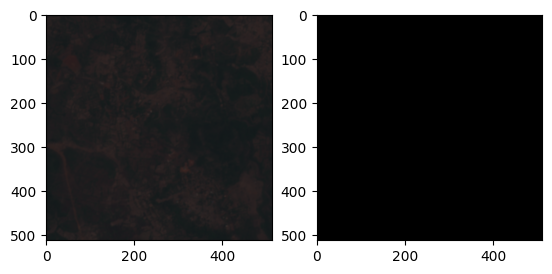

In [5]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [6]:
device='cuda'

eph=5
batch_size=16
lr=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=2

encoder='resnet50'
weights='imagenet'

In [7]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
)

In [8]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=encoder,
            encoder_weights=weights,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [9]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [10]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(device, dtype=torch.float32)
        masks=masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [11]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(device, dtype=torch.float32)
            masks=masks.to(device, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [12]:
optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #torch.optim.Adam(model.parameters(),lr=LR)

In [13]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

os.makedirs('model_performance', exist_ok = True)
os.makedirs('model_performance/' + encoder, exist_ok = True)


for i in range(eph):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss: #or valid_bce < best_val_bce_loss
        torch.save(model.state_dict(),"model_performance/{}/model_{:.5f}dice.pt".format(encoder, valid_dice))
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

  0%|▍                                                                              | 16/3347 [00:20<1:10:31,  1.27s/it]


KeyboardInterrupt: 